
#**1. Data Processing and Feature Engineering for AI Model 😎😎**


--------------------------------------------------------------------------------
## **1.1 Resampling the data and Combining weather data**

In [ ]:
# Data Processing for the AI model

import pandas as pd
import numpy as np
import holidays

# Getting the Dataset
df = pd.read_csv('combine_1.csv')

# Chaging the Time Column into Timestamp making it data_time for other processing
df.rename(columns = {'Time' : 'Timestamp'}, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resampling the data into 15 minutues (average value)
df = df.resample('15min').mean()


In [ ]:
# *** Obtaining the Weather Conditions from open-meteo API *** --> To inrease the accuracy of the AI model we need to give it more inputs to understand more patterns
import pandas as pd
import requests


# Copy the API URL address
api_url = "https://historical-forecast-api.open-meteo.com/v1/forecast?latitude=3.04&longitude=101.79&start_date=2023-04-03&end_date=2025-02-21&hourly=temperature_2m,relative_humidity_2m,apparent_temperature,cloud_cover,shortwave_radiation"

# Making request to the API
response = requests.get(api_url)
weather_data_json = response.json()

# Convert the JSON response to a pandas DataFrame
weather_df = pd.DataFrame(weather_data_json['hourly'])

# Convert the 'time' column to a proper dataframe object and set it as index
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df.set_index('time', inplace = True)

# Resampling and using interpolation to fill up the data in terms of 15 minutes, because we only have hourly data
weather_df_15mins = weather_df.resample('15min').interpolate(method = 'time')

print('Weather Data is successfully obtained and converted to a Dataframe, ready to be added to the main dataframe')
weather_df_15mins.head()

# *** Merging the Weather Data and the Power Consumption Data ***
df_combined = df.join(weather_df_15mins)
df_combined.drop(columns = ['cloud_cover', 'shortwave_radiation', 'relative_humidity_2m'], inplace = True)

# Verifying the merge of data
print(df_combined.head())

# Making request to the API
response = requests.get(api_url)
weather_data_json = response.json()

# Convert the JSON response to a pandas DataFrame
weather_df = pd.DataFrame(weather_data_json['hourly'])

# Convert the 'time' column to a proper dataframe object and set it as index
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df.set_index('time', inplace = True)

# Resampling and using interpolation to fill up the data in terms of 15 minutes, because we only have hourly data
weather_df_15mins = weather_df.resample('15min').interpolate(method = 'time')

print('Weather Data is successfully obtained and converted to a Dataframe, ready to be added to the main dataframe')
weather_df_15mins.head()

# *** Merging the Weather Data and the Power Consumption Data ***
df_combined = df.join(weather_df_15mins)
df_combined.drop(columns = ['cloud_cover', 'shortwave_radiation', 'relative_humidity_2m'], inplace = True)

# Verifying the merge of data
print(df_combined.head())

Weather Data is successfully obtained and converted to a Dataframe, ready to be added to the main dataframe
                         Pt(kW)     St(kVA)  temperature_2m  \
Timestamp                                                     
2023-04-03 00:00:00  102.181040  112.219760            24.5   
2023-04-03 00:15:00  101.205547  111.813920            24.6   
2023-04-03 00:30:00  101.452853  111.673440            24.7   
2023-04-03 00:45:00  102.504933  113.004240            24.8   
2023-04-03 01:00:00  100.501093  110.474853            24.9   

                     apparent_temperature  
Timestamp                                  
2023-04-03 00:00:00                 30.50  
2023-04-03 00:15:00                 30.65  
2023-04-03 00:30:00                 30.80  
2023-04-03 00:45:00                 30.95  
2023-04-03 01:00:00                 31.10  
Weather Data is successfully obtained and converted to a Dataframe, ready to be added to the main dataframe
                         Pt(kW)   

--------------------------------------------------------------------------------
## **1.2 Features Engineering, extracting information from the the timetamp**

In [ ]:
df_test = df_combined.loc['2023-04-03' : '2024-04-29']

In [ ]:
threshold = df_test['Pt(kW)'].quantile(0.95)

In [ ]:
threshold

np.float64(1060.25624)

In [ ]:
# Calendar Features
malaysia_holidays = holidays.MY()
df_combined['day_of_week'] = df_combined.index.day_of_week
df_combined['is_holiday'] = df_combined.index.isin(malaysia_holidays).astype(int)
df_combined['is_weekend'] = (df_combined['day_of_week'] == 5) | (df_combined['day_of_week'] == 6)
df_combined['is_weekend'] = df_combined['is_weekend'].astype(int)

# Getting the Time-Based Features
df_combined['hour_of_day'] = df_combined.index.hour
df_combined['minute_of_day']= df_combined.index.minute

# Using sin and cos for periodicity (15 minutes) --> Cylical Features for better model training
intervals_per_day = 24 * 4
df_combined['intervals_of_day'] = (df_combined['hour_of_day'] * 4) + (df_combined['minute_of_day'] / 15)
df_combined['intervals_sin'] = np.sin(2 * np.pi * df_combined['intervals_of_day'] / intervals_per_day)
df_combined['intervals_cos'] = np.cos(2 * np.pi * df_combined['intervals_of_day'] / intervals_per_day)

# Adding week of semester as an additional feature
# academic_periods = [
#     {'start' : '2024-01-29', 'end' : '2024-05-05', 'type': 'lecture'},
#     {'start' : '2024-05-06', 'end' : '2024-05-26', 'type' : 'exam'},
#     {'start' : '2024-05-27', 'end' : '2024-06-16', 'type' : 'break'},
#     {'start' : '2024-06-17', 'end' : '2024-09-22', 'type' : 'lecture'},
#     {'start' : '2024-09-23', 'end' : '2024-10-13', 'type' : 'exam'},
#     {'start' : '2024-10-14', 'end' : '2024-10-27', 'type' : 'break'},
#     {'start' : '2024-10-28', 'end' : '2024-12-15', 'type' : 'lecture'},
#     {'start' : '2024-12-16', 'end' : '2025-01-05', 'type' : 'exam'},
#     {'start' : '2025-01-06', 'end' : '2025-02-09', 'type' : 'break'},
#     {'start': '2025-02-10', 'end' : '2025-05-18', 'type' : 'lecture'}
# ]

# for period in academic_periods:
#   period['start'] = pd.to_datetime(period['start']).normalize()
#   period['end'] = pd.to_datetime(period['end']).normalize()

# def get_semester_week(date):
#   """
#   Returns the lecture week number (1-14/16) if the date is in a lecture period.
#   Otherwise, returns 0.
#   """
#   normalized_date = date.normalize()
#   for period in academic_periods:
#     if period['type'] == 'lecture' and period['start'] <= normalized_date <= period['end']:
#       week_number = (normalized_date - period['start']).days // 7 + 1
#       return week_number
#   return 0

# def is_exam_period(date):
#   """
#   Returns 1 if the date is in an exam period, 0 otherwise.
#   """
#   normalized_date = date.normalize()
#   for period in academic_periods:
#     if period['type'] == 'exam' and period['start'] <= normalized_date <= period['end']:
#       return 1

#   return 0

# df_combined['week_of_semester'] = df_combined.index.to_series().apply(get_semester_week)
# df_combined['is_exam_period'] = df_combined.index.to_series().apply(is_exam_period)


# Dropping the temporary features
columns_to_drop = ['hour_of_day', 'minute_of_day', 'intervals_of_day', 'St(kVA)']
df_combined.drop(columns = columns_to_drop, inplace = True)

# Function to create lagging features for the blocks of date due to gaps in the data
def create_lag_features(df, data_columns = ['Pt(kW)']):
  # Takes the continuous dataframe and adds the previous features
  df_featured = df.copy()

  # Adding the lagging features
  df_featured['load_t-15m'] = df_featured[data_columns].shift(1)
  df_featured['load_t-30m'] = df_featured[data_columns].shift(2)
  df_featured['load_t-45m'] = df_featured[data_columns].shift(3)
  df_featured['load_t-1h'] = df_featured[data_columns].shift(4)
  df_featured['load_same_time_last_week'] = df_featured[data_columns].shift(96 * 7)
  df_featured['load_t-24h'] = df_featured[data_columns].shift(96)
  df_featured['load_t-48h'] = df_featured[data_columns].shift(192)
  df_featured['load_t-72h'] = df_featured[data_columns].shift(288)

  return df_featured.dropna()

In [ ]:
# Defining the blocks based on the gaps of data to ensure continuity of timestamp

# Block 1 is from 03-04-2023 to 20-04-2023
block_1 = df_combined.loc[:'2023-04-20']

# Block 2 is from 25-04-2023 to 05-06-2023
block_2 = df_combined.loc['2023-04-25' : '2023-06-05']

# Block 3 is from 12-07-2023 to 21-07-2023
block_3 = df_combined.loc['2023-06-12' : '2023-07-21']

# Block 4 is from 24-07-2023 to 26-07-2023
block_4 = df_combined.loc['2023-07-24' : '2023-07-26']

# Block 5 is from 28-07-2023 to 08-09-2023
block_5 = df_combined.loc['2023-07-28' : '2023-09-08']

# Block 6 is from 10-09-2023 to 11-09-2023
block_6 = df_combined.loc['2023-09-10' : '2023-09-11']

# Block 7 is from 20-09-2023 to 20-10-2023
block_7 = df_combined.loc['2023-09-20' : '2023-10-20']

# Block 8 is from 23-10-2023 to 30-10-2023
block_8 = df_combined.loc['2023-10-23' : '2023-10-30']

# Block 8 is from 01-11-2023 to 04-01-2024
block_9 = df_combined.loc['2023-11-01' : '2024-01-04']

# Block 9 is from 10-01-2024 to 19-01-2024
block_10 = df_combined.loc['2024-01-10' : '2024-01-19']

# Block 10 is from 22-01-2024 onwards
block_11 = df_combined.loc['2024-01-22' : '2024-12-10' ]

# Block 11 is from 12-12-2024 onwards
block_12 = df_combined.loc['2024-12-12':]

# Create the lagging features (15 mins and the past week) separately
processed_block_1 = create_lag_features(block_1)
processed_block_2 = create_lag_features(block_2)
processed_block_3 = create_lag_features(block_3)
processed_block_4 = create_lag_features(block_4)
processed_block_5 = create_lag_features(block_5)
processed_block_6 = create_lag_features(block_6)
processed_block_7 = create_lag_features(block_7)
processed_block_8 = create_lag_features(block_8)
processed_block_9 = create_lag_features(block_9)
processed_block_10 = create_lag_features(block_10)
processed_block_11 = create_lag_features(block_11)
processed_block_12 = create_lag_features(block_12)

# Creating a list of the processed blocks
all_processed_blocks = [processed_block_1, processed_block_2, processed_block_3, processed_block_4, processed_block_5, processed_block_6, processed_block_7, processed_block_8, processed_block_9, processed_block_10, processed_block_11, processed_block_12]

# Concatenate all the blocks into one so that it can be put into one LSTM Model for training
df_final = pd.concat(all_processed_blocks)


--------------------------------------------------------------------------------
## **1.3 Splitting the data into training and testing set (80% split)**

In [ ]:
# *** From this stage, we are preparing the AI model training ***

# Importing the necessary libraries to perform the AI model training
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

# Reshaping the dataframe into numpy arrays for Analysis later --> The format that LSTM accepts
# The Target Column is the Pt(kW) --> This is the column that we want to predict and this is the Y-axis or the dependent variable
data_column = 'Pt(kW)'

# The y is the column that we want to predict --> The dependent variable
y = df_final[data_column]

# The X is the columns or the features that we want to use as input
X = df_final.drop(columns = [data_column])

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (55965, 15)
Shape of y: (55965,)


--------------------------------------------------------------------------------
## **1.4 Creating the Multi-Step Sequences**

In [ ]:
# *** Preparing the New Data Separation - Creating (History -> Future) Pairs ***
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_multi_step_sequence(data, n_steps_in, n_steps_out):
  """
  Converts the time series data into input (history) and output (future) windows
  """
  X, y = [], []
  for i in range(len(data)):
    # Finding the end of the pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out

    # Checking if we are beyond the dataset
    if out_end_ix > len(data):
      break

    # Gather the input and output parts of the pattern
    seq_x, seq_y = data[i:end_ix], data[end_ix : out_end_ix]
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)

# --- Defining the window size ---
# First, we are using the past 96 points to predict the next 24 hours
n_lookback = 96
n_forecast = 96

# --- Creating the full dataset for sequencing ---
data_for_sequencing = df_final.copy()

# The first column should be our target variable 'Pt(kW)' for this to work easily
cols = [data_column] + [col for col in df_final if col != data_column]
data_for_sequencing = data_for_sequencing[cols]

# --- Split Train / Test BEFORE creating the sequences to prevent data leakages ---
split_index = int(len(data_for_sequencing) * 0.50)
train_data = data_for_sequencing[:split_index]
test_data = data_for_sequencing[split_index:]

# --- Scaling the data ---
scaler = MinMaxScaler()
scaler.fit(train_data)

# Transform both the train and test data
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# --- Creating the final X and y sequences ---
X_train, y_train = create_multi_step_sequence(train_scaled, n_lookback, n_forecast)
X_test, y_test = create_multi_step_sequence(test_scaled, n_lookback, n_forecast)

# The 'y' data contains all the features, but we only want to predict the first column --> Pt(kW)
y_train = y_train[:, :, 0]
y_test = y_test[:, :, 0]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (27791, 96, 16)
Shape of y_train: (27791, 96)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
# **2. Defining the Model Architecture and Training the AI Model 💪💪**

In [ ]:
from tensorflow.keras.layers import GRU, Dropout

# Assume n_lookback=60, n_features=(your number), n_forecast=15

n_features = X_train.shape[2]
n_forecast = 1

# Define the model
tactical_model = Sequential(name="Tactical_15min_GRU")
tactical_model.add(Input(shape=(n_lookback, n_features)))

# A GRU layer is fast and effective for this shorter task
tactical_model.add(GRU(units=100, activation='tanh'))
tactical_model.add(Dropout(0.2))

# Output layer has 15 neurons for the 15-minute forecast
tactical_model.add(Dense(units=n_forecast))

tactical_model.compile(optimizer='adam', loss='mean_absolute_error')
tactical_model.summary()

Model: "Tactical_15min_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100)            │        35,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,501 (138.68 KB)

 Trainable params: 35,501 (138.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights= True)
history = tactical_model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test), callbacks = [early_stopping])

Epoch 1/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0478 - val_loss: 0.0124
Epoch 2/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0204 - val_loss: 0.0123
Epoch 3/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0180 - val_loss: 0.0127
Epoch 4/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0172 - val_loss: 0.0099
Epoch 5/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0170 - val_loss: 0.0110
Epoch 6/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0166 - val_loss: 0.0107
Epoch 7/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0166 - val_loss: 0.0135
Epoch 8/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0164 - val_loss: 0.0093
Epoch 9/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0160 - val_loss: 0.0142
Epoch 10/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0162 - val_loss: 0.0091
Epoch 11/100
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0164 - val_loss: 0.0115
Epoch 12

--------------------------------------------------------------------------------
## **2.1 Setting up the model architecture and training the AI model**

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

# Use this new architecture with your Direct Multi-Step data
# n_lookback = 96, n_features = (your number), n_forecast = 96

model = Sequential()
model.add(Input(shape=(n_lookback, X_train.shape[2])))

# CNN layer to find local patterns in the input sequence
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
# Optional: A pooling layer to summarize the findings
model.add(MaxPooling1D(pool_size=2))

# LSTM layer to understand the sequence of the patterns found by the CNN
model.add(LSTM(300, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(n_forecast))

model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 92, 64)         │         5,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 300)            │       438,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        28,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,720 (1.80 MB)

 Trainable params: 472,720 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Training the model ---
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights= True)
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test), callbacks = [early_stopping])

Epoch 1/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1127 - val_loss: 0.0665
Epoch 2/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0572 - val_loss: 0.0587
Epoch 3/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0492 - val_loss: 0.0638
Epoch 4/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0484 - val_loss: 0.0555
Epoch 5/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0452 - val_loss: 0.0538
Epoch 6/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0440 - val_loss: 0.0535
Epoch 7/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0440 - val_loss: 0.0558
Epoch 8/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0430 - val_loss: 0.0545
Epoch 9/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0422 - val_loss: 0.0514
Epoch 10/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0420 - val_loss: 0.0526
Epoch 11/100
869/869 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0419 - val_loss: 0.0602
Epoch 12/100
869/86

--------------------------------------------------------------------------------
## **2.2 Saving the model into Google Drive so that it can be retrieved**

In [ ]:
# *** Saving the models and the scalers into Google Drive so that it can be called at any time ***

# Connecting Google Drive to this Colab Workspace

from google.colab import drive
print("Connecting to Google Drive")
drive.mount('/content/drive')
print ("Google Drive is connected successfully")


# Defining the full paths for the files that will be saved later
from pathlib import Path
import joblib

# Defining the project path
project_path = Path('/content/drive/MyDrive/FYP Project - Designing a controller to reduce peak demand')


model_path = project_path / 'short_term_prediction.keras'
scaler_path = project_path / 'short_term_prediction.pkl'


print(f"Model will be saved to {model_path}")
print(f"Scaler will be saved to {scaler_path}")
# import joblib # For saving the scalers

# Saving the keras model
tactical_model.save(model_path)

# Saving the scalers using joblib library
joblib.dump(scaler, scaler_path)

print("The models and the scalers are saved in the Google Drive successfully")

Connecting to Google Drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive is connected successfully
Model will be saved to /content/drive/MyDrive/FYP Project - Designing a controller to reduce peak demand/short_term_prediction.keras
Scaler will be saved to /content/drive/MyDrive/FYP Project - Designing a controller to reduce peak demand/short_term_prediction.pkl
The models and the scalers are saved in the Google Drive successfully


--------------------------------------------------------------------------------
## **2.3 Evaluating the performance of the model using graphical methods and finding the MAE**

869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
--- Inverse scaling the results ---

--- Calculating Final Performance ---
Direct Multi-Step Model MAE: 56.16 kW
Direct Multi-Step Model MAPE: 18.82%

--- Plotting an example 24-hour forecast ---


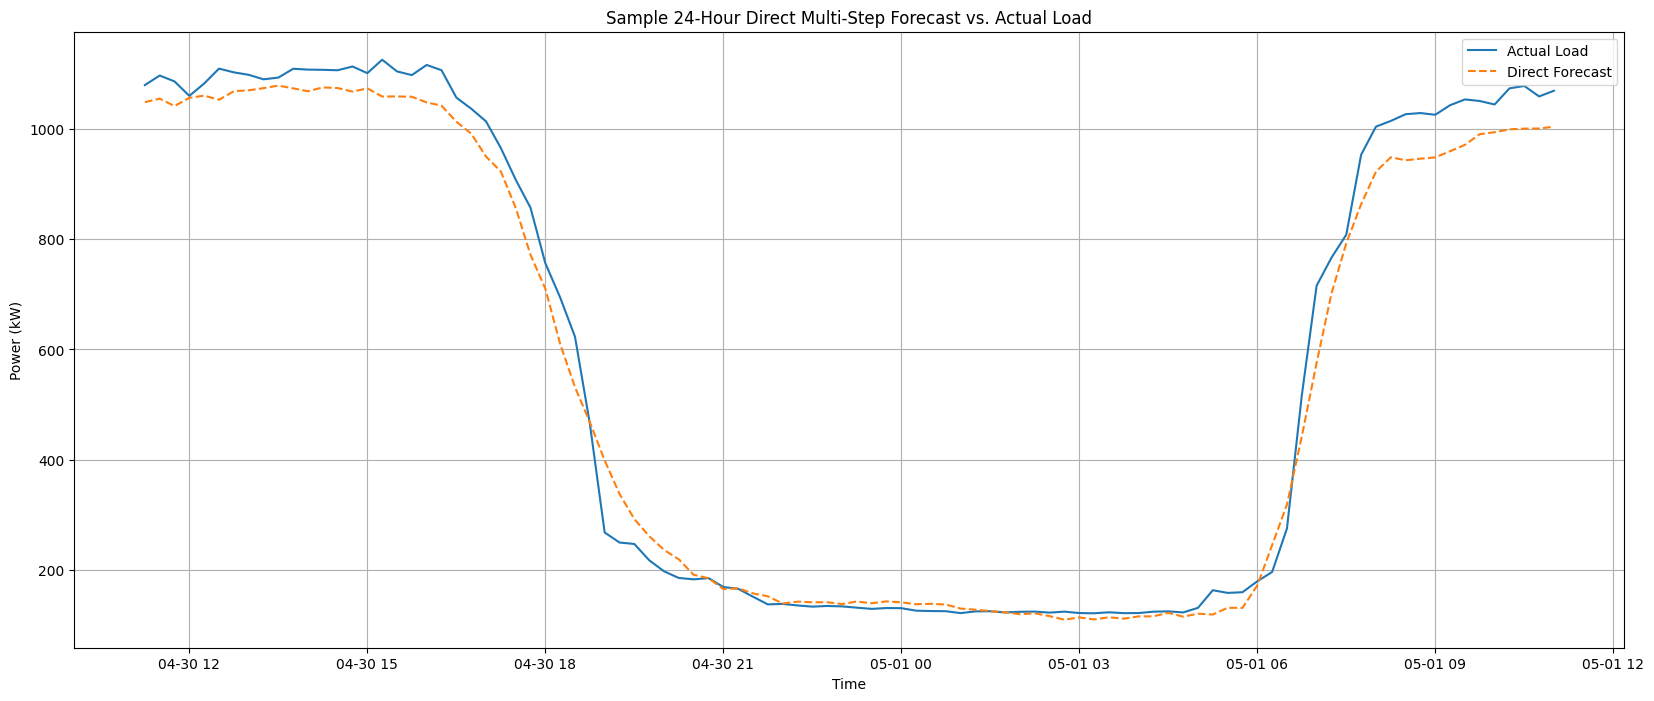

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assume 'model', 'scaler', 'X_test', and 'y_test' are ready from your training step

# --- Step 1: Make Predictions ---
# predictions_scaled will have a shape like (e.g., 11002, 96)
predictions_scaled = model.predict(X_test)


# --- Step 2: The Corrected Inverse Transform Logic ---
print("--- Inverse scaling the results ---")

# Get the number of samples and features for reshaping
n_test_samples = X_test.shape[0]
n_features = X_train.shape[2] # Number of columns in your original data

# --- Process the PREDICTIONS ---
# 1a. Create a dummy array with the right shape (all test predictions * all features)
dummy_pred = np.zeros((n_test_samples * n_forecast, n_features))
# 1b. Put the flattened predictions into the first column (the 'Pt(kW)' position)
dummy_pred[:, 0] = predictions_scaled.flatten()
# 1c. Inverse transform the entire dummy array
inversed_pred = scaler.inverse_transform(dummy_pred)
# 1d. Extract the first column and reshape it back to our (samples, 96) forecast format
predictions_kw = inversed_pred[:, 0].reshape(n_test_samples, n_forecast)


# --- Process the ACTUALS (y_test) in the exact same way for a fair comparison ---
# 2a. Create the dummy array for y_test
dummy_y = np.zeros((n_test_samples * n_forecast, n_features))
# 2b. Put the flattened y_test values into the first column
dummy_y[:, 0] = y_test.flatten()
# 2c. Inverse transform
inversed_y = scaler.inverse_transform(dummy_y)
# 2d. Extract and reshape
y_test_kw = inversed_y[:, 0].reshape(n_test_samples, n_forecast)


# --- Step 3: Calculate MAE and Plot Safely ---
print("\n--- Calculating Final Performance ---")

# Now we can safely calculate the MAE on the correctly scaled data
mae = mean_absolute_error(y_test_kw.flatten(), predictions_kw.flatten())
mape = np.mean(np.abs((y_test_kw - predictions_kw) / (y_test_kw + 1e-6))) * 100

print(f"Direct Multi-Step Model MAE: {mae:.2f} kW")
print(f"Direct Multi-Step Model MAPE: {mape:.2f}%")


# --- Plot the first prediction from the test set as an example ---
print("\n--- Plotting an example 24-hour forecast ---")

# Get the correct timestamps for our plot's x-axis
# This requires looking back at the original test_data DataFrame
plot_start_index = n_lookback + n_forecast - 1
plot_index = test_data.index[plot_start_index:plot_start_index + n_forecast]


plt.figure(figsize=(20, 8))
plt.plot(plot_index, y_test_kw[0], label='Actual Load')
plt.plot(plot_index, predictions_kw[0], label='Direct Forecast', linestyle='--')
plt.title('Sample 24-Hour Direct Multi-Step Forecast vs. Actual Load')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assume you have these results from the previous step:
# y_test_kw (e.g., shape (11002, 96))
# predictions_kw (e.g., shape (11002, 96))

print("--- Calculating the MAE for each 24-hour forecast in the test set ---")

daily_maes = []
for i in range(len(y_test_kw)):
    # Calculate the MAE for the i-th 24-hour forecast
    day_mae = mean_absolute_error(y_test_kw[i], predictions_kw[i])
    daily_maes.append(day_mae)

# Create a new DataFrame to analyze these errors
evaluation_df = pd.DataFrame()
evaluation_df['mae_kw'] = daily_maes

print("Error analysis complete.")
print("\nDescription of daily errors:")
print(evaluation_df['mae_kw'].describe())

--- Calculating the MAE for each 24-hour forecast in the test set ---
Error analysis complete.

Description of daily errors:
count    27792.000000
mean        56.158990
std         44.514598
min          8.972060
25%         32.527261
50%         42.457983
75%         61.448904
max        379.381604
Name: mae_kw, dtype: float64


--------------------------------------------------------------------------------
## **2.4 Plotting the predictions based on 96 samples (one day)**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import the date formatting library
import pandas as pd

def plot_forecast(actuals, predictions, idx_to_plot, title=""):
    """
    Plots a single 24-hour forecast vs. the actual values with corrected time axis.
    """

    # --- THE FIX IS HERE ---
    # Instead of just the time, we create a full DatetimeIndex for a sample 24-hour period.
    # This gives matplotlib the context it needs to plot the data correctly.
    plot_index = pd.date_range(start="2024-01-01 00:00", periods=96, freq="15min")
    # --- END OF FIX ---

    plt.figure(figsize=(20, 8))

    # Plotting now uses the full DatetimeIndex for the x-axis
    plt.plot(plot_index, actuals[idx_to_plot], label='Actual Load', color='blue', linewidth=2)
    plt.plot(plot_index, predictions[idx_to_plot], label='Direct Forecast', color='red', linestyle='--', alpha=0.9)

    plt.title(f'{title} (Sample Index: {idx_to_plot})')
    plt.xlabel('Time of Day')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True)

    # --- FORMAT THE X-AXIS TO SHOW ONLY THE TIME ---
    # This formats the labels on the axis to look like 'HH:MM' (e.g., '08:00')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2)) # Set a major tick every 2 hours
    plt.gcf().autofmt_xdate() # Auto-formats the rotated labels to fit nicely

    plt.show()

In [ ]:
# Find the index of the best (lowest MAE) and worst (highest MAE) forecasts
best_forecast_idx = evaluation_df['mae_kw'].idxmin()
worst_forecast_idx = evaluation_df['mae_kw'].idxmax()

# Find the index of a forecast that is close to the average (median) performance
median_mae = evaluation_df['mae_kw'].median()
# Find the index of the forecast whose MAE is closest to the median MAE
average_forecast_idx = (evaluation_df['mae_kw'] - median_mae).abs().idxmin()

print(f"\nBest forecast is at sample index: {best_forecast_idx} (MAE: {evaluation_df.loc[best_forecast_idx, 'mae_kw']:.2f} kW)")
print(f"Worst forecast is at sample index: {worst_forecast_idx} (MAE: {evaluation_df.loc[worst_forecast_idx, 'mae_kw']:.2f} kW)")
print(f"An average forecast is at sample index: {average_forecast_idx} (MAE: {evaluation_df.loc[average_forecast_idx, 'mae_kw']:.2f} kW)")


Best forecast is at sample index: 13994 (MAE: 7.07 kW)
Worst forecast is at sample index: 25669 (MAE: 370.26 kW)
An average forecast is at sample index: 15156 (MAE: 38.41 kW)


--------------------------------------------------------------------------------
## **2.5 Choosing a day, make a prediction and compare with the actual results**

--- Preparing input data for target date: 2024-04-30 ---
✅ Input data successfully sliced.
--- Making prediction with the model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
✅ Forecast generated successfully.

--- Results for 2024-04-30 ---
Mean Absolute Error (MAE): 18.42 kW


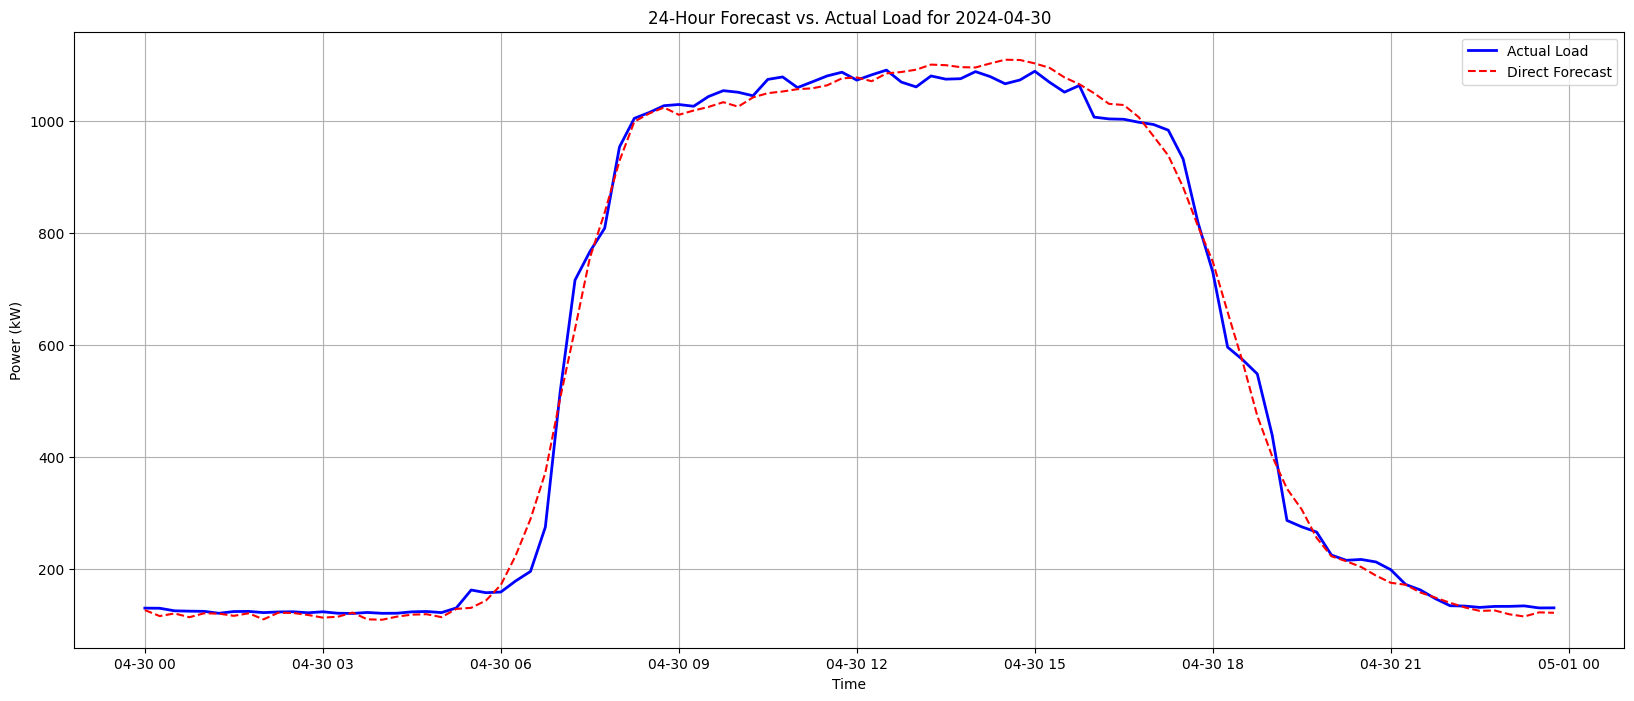

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Setup Your Test Scenario ===

# ==> YOUR ACTION: Choose any date you want to test from your dataset.
# Make sure the day BEFORE this date also exists in your data.
TARGET_DATE = '2024-04-30'

# Define the model parameters (these MUST match how your model was trained)
n_lookback = 96  # The history window (e.g., 24 hours)
n_forecast = 96  # The forecast window (e.g., 24 hours)
# Get the feature order from the scaler itself for robustness
feature_order = scaler.get_feature_names_out()
n_features = len(feature_order)
# Get the name of your target column (it's the first one in our setup)
data_column = feature_order[0]


# === Step 2: Prepare the Input Data (The Lookback Window) ===

print(f"--- Preparing input data for target date: {TARGET_DATE} ---")

# We need the full 24 hours of data from the day BEFORE our target date.
lookback_start_date = pd.to_datetime(TARGET_DATE) - pd.Timedelta(days=1)
lookback_start_str = lookback_start_date.strftime('%Y-%m-%d')

# Slice the lookback data from your main DataFrame
try:
    lookback_data = df_final.loc[lookback_start_str, feature_order]

    # Sanity check to make sure we have a full day of history
    if len(lookback_data) != n_lookback:
        print(f"⚠️ Warning: Lookback data for {lookback_start_str} is incomplete. It has {len(lookback_data)} rows instead of {n_lookback}.")
        # Handle this case if necessary, for now we will proceed

    print("✅ Input data successfully sliced.")

except KeyError:
    print(f"❌ Error: The historical data for {lookback_start_str} does not exist. Please choose a different target date.")
    # Stop the process if the data isn't there
    lookback_data = None


# === Step 3: Scale, Reshape, and Predict ===

if lookback_data is not None:
    # Scale the lookback data using the loaded scaler
    lookback_scaled = scaler.transform(lookback_data)

    # Reshape for the model: [1 sample, 96 timesteps, N features]
    input_for_model = lookback_scaled.reshape((1, n_lookback, n_features))

    # Make the 24-hour forecast in one shot
    print("--- Making prediction with the model ---")
    prediction_scaled = model.predict(input_for_model)


    # === Step 4: Inverse Scale and Format the Output ===

    # Use the dummy array trick to inverse transform the prediction
    dummy_pred = np.zeros((1 * n_forecast, n_features))
    dummy_pred[:, 0] = prediction_scaled.flatten()
    inversed_pred = scaler.inverse_transform(dummy_pred)

    # This is your final forecast in real kW values
    forecast_values = inversed_pred[:, 0]

    # Create a DataFrame for the forecast with the correct time index
    forecast_index = pd.date_range(start=TARGET_DATE, periods=96, freq='15min')
    forecast_df = pd.DataFrame({'Forecast': forecast_values}, index=forecast_index)
    print("✅ Forecast generated successfully.")


    # === Step 5: Compare with Actuals and Visualize ===

    # Get the actual values for the target day for comparison
    actual_load = df_final.loc[TARGET_DATE, data_column]

    # Calculate the MAE for this specific day
    mae = mean_absolute_error(actual_load, forecast_df['Forecast'])
    print(f"\n--- Results for {TARGET_DATE} ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f} kW")

    # Plot the results
    plt.figure(figsize=(20, 8))
    plt.plot(actual_load, label='Actual Load', color='blue', linewidth=2)
    plt.plot(forecast_df['Forecast'], label='Direct Forecast', color='red', linestyle='--')
    plt.title(f'24-Hour Forecast vs. Actual Load for {TARGET_DATE}')
    plt.xlabel('Time')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.show()

--------------------------------------------------------------------------------
# **3. Peak Demand Reduction Controller** ⚡⚡

--------------------------------------------------------------------------------
## **3.1 Loading the Pre-Trained Model for Forecasting Load Profile**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from pathlib import Path

# Load the pre-trained models to be used later
from google.colab import drive
drive.mount('/content/drive')

# Defining the path for the files or the folders
project_folder = Path('/content/drive/MyDrive/FYP Project - Designing a controller to reduce peak demand')
model_path = project_folder / 'load_forecasting_lstm_model4.keras'
scaler_path = project_folder / 'scaler4.pkl'

# Loading the models
model_loaded = load_model(model_path)
scaler= joblib.load(scaler_path)

Mounted at /content/drive


In [ ]:
df_final.loc['2024-11-29']

,Pt(kW),temperature_2m,apparent_temperature,day_of_week,is_holiday,is_weekend,intervals_sin,intervals_cos,week_of_semester,is_exam_period,load_t-15m,load_t-30m,load_t-45m,load_t-1h,load_same_time_last_week,load_t-24h,load_t-48h,load_t-72h
Timestamp,,,,,,,,,,,,,,,,,,
2024-11-29 00:00:00,88.406667,24.400,30.300,4,0,0,0.000000,1.000000,5,0,93.733333,88.910000,94.163333,93.678333,93.133333,89.116667,95.728333,92.105000
2024-11-29 00:15:00,89.876667,24.500,30.425,4,0,0,0.065403,0.997859,5,0,88.406667,93.733333,88.910000,94.163333,92.100000,89.220000,91.686667,89.603333
2024-11-29 00:30:00,89.196667,24.600,30.550,4,0,0,0.130526,0.991445,5,0,89.876667,88.406667,93.733333,88.910000,90.066667,85.981667,93.221667,92.775000
2024-11-29 00:45:00,85.571667,24.700,30.675,4,0,0,0.195090,0.980785,5,0,89.196667,89.876667,88.406667,93.733333,88.595000,89.151667,93.398333,90.156667
2024-11-29 01:00:00,87.841667,24.800,30.800,4,0,0,0.258819,0.965926,5,0,85.571667,89.196667,89.876667,88.406667,86.701667,87.091667,92.830000,90.441667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29 22:45:00,94.401667,24.050,29.250,4,0,0,-0.321439,0.946930,5,0,95.605000,95.950000,97.656667,109.061667,95.081667,94.371667,97.756667,100.025000
2024-11-29 23:00:00,94.976667,24.000,29.200,4,0,0,-0.258819,0.965926,5,0,94.401667,95.605000,95.950000,97.656667,90.536667,93.678333,92.995000,97.268333
2024-11-29 23:15:00,95.293333,24.075,29.300,4,0,0,-0.195090,0.980785,5,0,94.976667,94.401667,95.605000,95.950000,97.066667,94.163333,95.095000,98.948333


--------------------------------------------------------------------------------
## **3.2 Setting up a RATIONING logic to adjust the threshold if the battery capacity is not enough**

In [ ]:
scaler.scale_.shape

(12,)

In [ ]:
import numpy as np
import pandas as pd

def calculate_effective_threshold(
    forecasted_load,
    initial_threshold,
    available_energy_kwh,
    max_power_kw = 100.0, # Added parameter for maximum discharge power
    interval_hours = 1 / 60): # Changed default interval to 5 minutes

  """
  Calculates the optimal peak shaving threshold by checking if the rationing logic is needed --> or rather if the battery capacity that handle the entire duration without adjustment

  Returns:
    The final, effective threshold (in kW) to be used for the day.
  """

  # Identify all the intervals where the load is more than the threshold set
  peak_intervals = forecasted_load[forecasted_load > initial_threshold]

  # If there is no peak to reduce, do nothing
  if peak_intervals.empty:
    return initial_threshold

  # Calculate the power needed in each peak interval, capped by max_power_kw
  power_needed_in_peaks = (peak_intervals - initial_threshold).clip(upper=max_power_kw)


  # Calculating the entire energy that is needed to reduce the demand based on the initial threshold
  # Use the capped power for energy calculation
  energy_needed_kwh = power_needed_in_peaks.sum() * interval_hours


  # Check if the battery has enough capacity for the energy that is needed
  if energy_needed_kwh <= available_energy_kwh:
    print(f"Initial threshold {initial_threshold:.2f} kW is feasible with available energy {available_energy_kwh:.2f} kWh.")
    return initial_threshold


  # Don't have enough energy --> Have to change the effective threshold to cover the entire peak
  print(f"Not enough available energy ({available_energy_kwh:.2f} kWh) for initial threshold {initial_threshold:.2f} kW (requires {energy_needed_kwh:.2f} kWh). Calculating a new, higher threshold...")

  effective_threshold = initial_threshold

  # A while loop to raise the threshold by 1kW and see if the battery has enough energy to cover the energy that is needed
  while energy_needed_kwh > available_energy_kwh:
    effective_threshold += 1

    new_peak_intervals = forecasted_load[forecasted_load > effective_threshold]

    if new_peak_intervals.empty:
      effective_threshold = forecasted_load.max() # This is the absolute LIMIT, is just a failsafe
      print(f"Reached maximum load {effective_threshold:.2f} kW while adjusting threshold.")
      break

    # Calculate the power needed for the new threshold, again capped by max_power_kw
    new_power_needed_in_peaks = (new_peak_intervals - effective_threshold).clip(upper=max_power_kw)

    # Recalculate energy needed with the new threshold and capped power
    energy_needed_kwh = new_power_needed_in_peaks.sum() * interval_hours


  print(f"Effective threshold adjusted to {effective_threshold:.2f} kW (requires {energy_needed_kwh:.2f} kWh).")
  return effective_threshold

--------------------------------------------------------------------------------
## **3.3 Setting up the Function to reduce daily peak demand including Charging and Discharging of the battery system**

In [ ]:
import numpy as np
import pandas as pd

# The Final, Corrected, and most advanced simulation function
def simulate_daily_peak_reduction(
    forecasted_load,
    actual_load,
    battery_capacity,
    max_power,
    initial_soc,
    shaving_percentage,
    target_date,
    target_month,
    safety_margin= 0.0,
    replan_buffer = 0.20,
    efficiency=0.90
):
    """
    Simulates peak shaving using a hybrid strategy:
    1. Proactively plans a threshold based on the full-day forecast.
    2. Reactively executes dispatch based on the actual load.
    """

    print("--- Running Hybrid Simulation (Proactive Plan, Reactive Execution) ---")

    # --- 1. STRATEGIC PLANNING PHASE (Done once at the start) ---
    plannable_energy = initial_soc * (1 - safety_margin)
    initial_threshold = forecasted_load.max() * (1 - shaving_percentage)
    # The 'Captain's Plan': Calculate the single best threshold for the day based on the forecast
    planned_threshold = calculate_effective_threshold( # Using the function from before
        forecasted_load, initial_threshold, plannable_energy
    )
    print(f"Strategic threshold for the day set to: {planned_threshold:.2f} kW")

    planned_dispatch = (forecasted_load.clip(lower = planned_threshold) - planned_threshold).clip(upper = max_power)
    planned_soc_trajectory = pd.Series(initial_soc - planned_dispatch.cumsum() * (1/60), index = forecasted_load.index)

    # Also based on the forecast, identify the best hours to recharge
    energy_used_in_plan = (forecasted_load[forecasted_load > planned_threshold] - planned_threshold).sum() * (1/60)
    energy_needed_from_grid = energy_used_in_plan / efficiency
    num_charge_intervals = int(np.ceil((energy_needed_from_grid / max_power) / (1/60)))
    charge_indices = np.argsort(forecasted_load.values)[:num_charge_intervals]

    # --- 2. TACTICAL EXECUTION PHASE (Loop through the day) ---
    num_intervals = len(forecasted_load)
    interval_hours = 1/60

    battery_dispatch_kw = np.zeros(num_intervals)
    soc_kwh = np.zeros(num_intervals + 1)
    soc_kwh[0] = initial_soc
    energy_discharged_so_far = 0.0
    threshold_over_time = np.full(num_intervals, planned_threshold)

    final_threshold = planned_threshold

    has_replanned1 = False
    has_replaned2 = False
    has_replanned3 = False
    recent_errors = []

    # Defining a scaling factor (tuning parameter)

    for i in range(num_intervals):
        current_soc = soc_kwh[i]
        current_hour = actual_load.index[i].hour
        current_minute = actual_load.index[i].minute
        dispatch_kw = 0
        # final_threshold = 1060.25624

        # if (target_month == 1):
        #   final_threshold = 889.8955226666666
        # elif (target_month == 2):
        #   final_threshold = 1077.0403333333334
        # elif (target_month == 3):
        #   final_threshold = 1104.6216666666667
        # elif (target_month == 4):
        #   final_threshold = 1085.4683906666667
        # elif(target_month == 5):
        #   final_threshold = 1095.7654333333332
        # elif(target_month == 6):
        #   final_threshold = 1039.698564
        # elif(target_month == 7):
        #   final_threshold = 1037.6471186666668
        # elif (target_month == 8):
        #   final_threshold = 1067.7494333333334
        # elif (target_month == 9):
        #   final_threshold = 1004.6357133333333
        # elif (target_month == 10):
        #   final_threshold = 966.334928
        # elif (target_month == 11):
        #   final_threshild = 950.7196146666666
        # elif (target_month == 12):
        #   final_threshold = 912.1429066666666
        # print(final_threshold)

        # if (current_hour > 8):
        #    current_error = actual_load.iloc[i-5:i].mean() - forecasted_load.iloc[i-5 : i].mean()
        #    final_threshold = planned_threshold + np.mean(current_error)

        # if current_hour > 7 and current_hour < 17:

        #   energy_required = (actual_load.iloc[i-1] - final_threshold) * (17 - current_hour)

        #   while (current_soc < energy_required):
        #     final_threshold += 1
        #     energy_required = (actual_load.iloc[i-1] - final_threshold) * (17 - current_hour)

        # if (current_hour == 9 and not has_replanned1):
        #   current_error = actual_load.iloc[i-1] - forecasted_load.iloc[i-1]
        #   final_threshold = planned_threshold + current_error
        #   has_replanned1 = True

        # if (current_hour > 8):
        #   current_error = actual_load.iloc[i-1] - forecasted_load.iloc[i-1]
        #   recent_errors.append(current_error)
        #   final_threshold = planned_threshold + np.mean(recent_errors)

        #   final_threshold = planned_threshold + np.mean(recent_errors)
        #   print(final_threshold)
        # if current_hour >= 9:
        #   recent_errors.append(current_error)

        # if (current_hour == 10 and current_minute == 0): # Replan the threshold setting at 10AM
        #   current_error = actual_load.iloc[i-1] - forecasted_load.iloc[i-1]
        #   final_threshold = planned_threshold + current_error
        #   has_replanned1 = True



          # print(f"The newly adjusted threshold at 10AM is {final_threshold}")

        # if (current_hour == 12 and current_minute == 0):
        #   if len(recent_errors) > 0:
        #     average_error_kw = np.mean(recent_errors)
        #     final_threshold = planned_threshold + average_error_kw

        # if (current_hour == 9 and current_minute == 0):
        #   last_interval_error = actual_load.iloc[i-1] - forecasted_load.iloc[i-1]
        #   final_threshold = planned_threshold + last_interval_error
        #   print(f"The newly adjusted threshold at 12PM is {final_threshold} ")


        # if (current_hour == 12 and current_minute == 0):
        #   last_interval_error = actual_load.iloc[i-1] - forecasted_load.iloc[i-1]
        #   final_threshold = planned_threshold + last_interval_error
        #   print(f"The newly adjusted threshold at 12PM is {final_threshold} ")


        threshold_over_time[i] = final_threshold

        # --- The 'Helmsman's' Logic ---
        # Priority 1: Is this a designated charging slot?
        if i in charge_indices:
            energy_room = battery_capacity - current_soc
            power_limit_by_room = energy_room / interval_hours
            power_to_charge = min(max_power, power_limit_by_room)
            dispatch_kw = -power_to_charge

        # Priority 2: If not charging, should we discharge?
        # The decision is now based on the ACTUAL load crossing the smart threshold
        elif actual_load.iloc[i] > final_threshold and current_soc > 0:
            # print(final_threshold)
            excess_power = actual_load.iloc[i] - final_threshold
            # print(f"Actual Load : {actual_load.iloc[i]}, Excess Power : {excess_power}, Final Threshold {final_threshold}, Planned Threshold {planned_threshold}, Forecast Error {current_error}")
            power_to_discharge = min(excess_power, max_power)
            power_limit_by_energy = current_soc / interval_hours
            dispatch_kw = min(power_to_discharge, power_limit_by_energy)

        # Update state based on the final action
        battery_dispatch_kw[i] = dispatch_kw
        energy_change = -dispatch_kw * interval_hours

        if dispatch_kw < 0: # Charging efficiency loss
            energy_change *= efficiency
        soc_kwh[i+1] = np.clip(soc_kwh[i] + energy_change, 0, battery_capacity)

        if dispatch_kw > 0:
          energy_discharged_so_far += dispatch_kw * interval_hours

    # --- 3. Final Results ---

    results = {
        "final_shaved_load": pd.Series(actual_load.values - battery_dispatch_kw, index=actual_load.index),
        "battery_soc_kwh": pd.Series(soc_kwh, index=pd.date_range(start=actual_load.index[0], periods=num_intervals + 1, freq='1min')),
        "final_threshold": final_threshold,
        "threshold_over_time": pd.Series(threshold_over_time, index = actual_load.index),
        # "short_term_forecast": pd.Series(short_term_predictions, index = actual_load.index),
        "Forecast_kW" : forecasted_load
    }
    return results

--------------------------------------------------------------------------------
## **3.4 Testing the peak reduction logic with exact day, simulating the day, setting up the specifications of the battery system**

--- Preparing Simulation for Target Date: 2025-01-03 ---

Step 1: Generating the 24-hour forecast...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ Forecast generated successfully.

Step 2: Running the peak shaving simulation using the forecast...
--- Running Hybrid Simulation (Proactive Plan, Reactive Execution) ---
Not enough available energy (120.00 kWh) for initial threshold 905.44 kW (requires 782.70 kWh). Calculating a new, higher threshold...
Effective threshold adjusted to 1019.44 kW (requires 117.09 kWh).
Strategic threshold for the day set to: 1019.44 kW
✅ Simulation complete.

Step 3: Analyzing and plotting the final outcome...
845.4833333333333 845.4833333333333
0.0

--- Final Simulation Results ---
Original Actual Peak: 888.60 kW
New Simulated Peak:   888.60 kW
Peak Demand Reduced:  0.00 kW (0.00%)


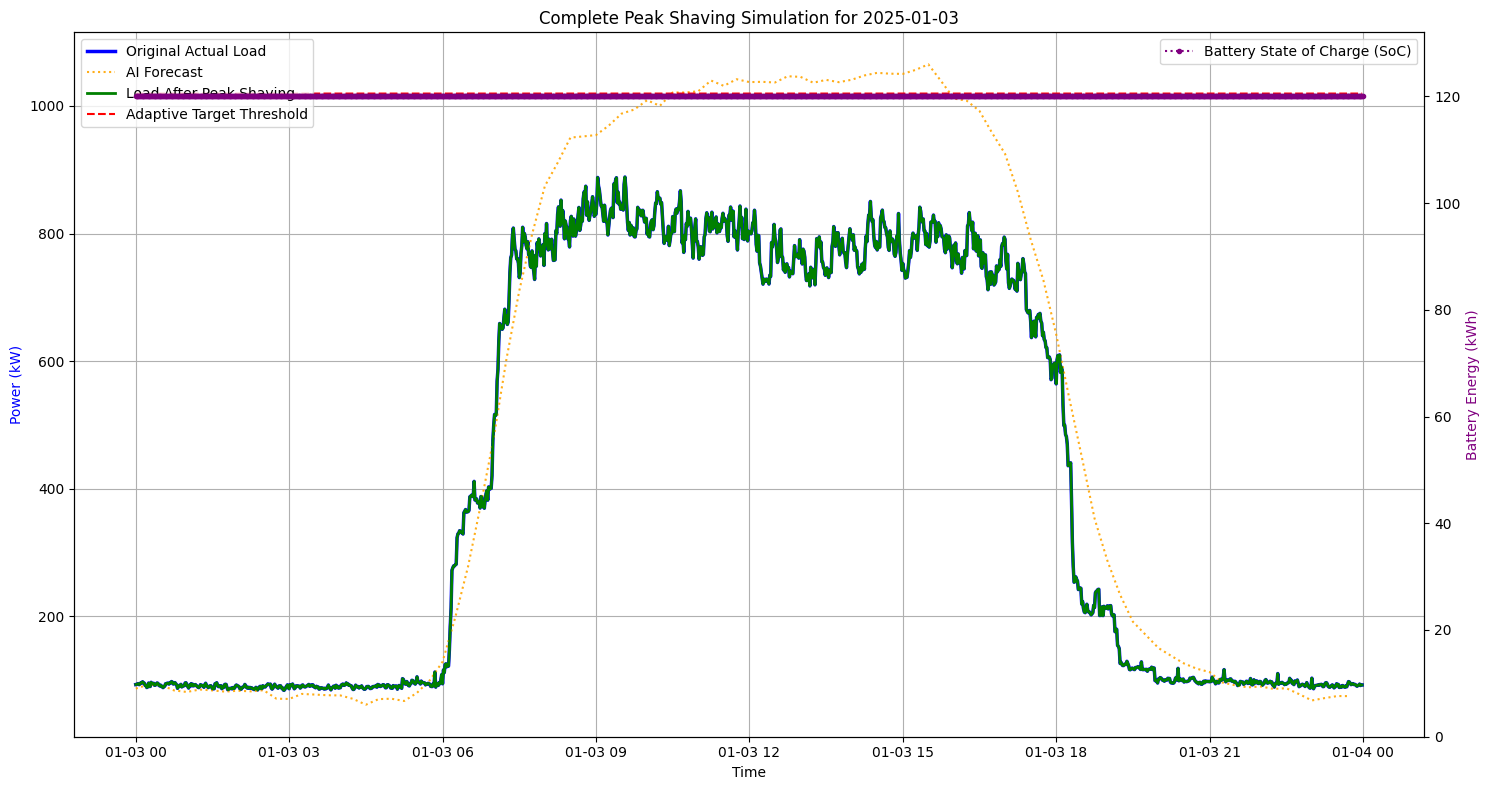

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import os

# For this script, we assume you have ALREADY loaded the following:
# model: Your trained Direct Multi-Step Keras model
# scaler: Your fitted MinMaxScaler object
# df_final: Your complete, cleaned, and feature-rich historical DataFrame
# create_multi_step_sequences: The helper function for data prep (if needed for comparison)

# --- ====================================================================== ---
# === Part 1: SETUP & CONFIGURATION ===
# --- ====================================================================== ---

# ==> YOUR ACTION: Choose the specific day you want to run the simulation for
TARGET_DATE = '2025-01-03'

# --- Model & Data Parameters (MUST match your training setup) ---
n_lookback = 96  # History window (24 hours)
n_forecast = 96  # Forecast window (24 hours)
feature_order = scaler.get_feature_names_out() # Get feature order from the scaler
n_features = len(feature_order)
data_column = feature_order[0] # Your target variable, e.g., 'Pt(kW)'

# --- Battery & Strategy Parameters ---
BATTERY_CAPACITY_KWH = 120.0
BATTERY_MAX_POWER_KW = 100.0
INITIAL_SOC_KWH = BATTERY_CAPACITY_KWH
BATTERY_EFFICIENCY = 0.90
SHAVING_PERCENTAGE = 0.15 # Target to shave 10% off the forecasted peak
# SAFETY_MARGIN = 0.0

print(f"--- Preparing Simulation for Target Date: {TARGET_DATE} ---")


# --- ====================================================================== ---
# === Part 2: GENERATE THE DAY-AHEAD FORECAST ===
# --- ====================================================================== ---
print("\nStep 1: Generating the 24-hour forecast...")

# a) Get the 24-hour lookback window from the day BEFORE the target date
lookback_start_date = pd.to_datetime(TARGET_DATE) - pd.Timedelta(days=1)
lookback_start_str = lookback_start_date.strftime('%Y-%m-%d')
target_date = pd.to_datetime(TARGET_DATE)
target_month = target_date.month
# For 192 lookback, which means looking back 2 days
# lookback_end_date = pd.to_datetime(TARGET_DATE) - pd.Timedelta(minutes = 15)
# lookback_end_str = lookback_end_date.strftime('%Y-%m-%d')

lookback_data_raw = df_final.loc[lookback_start_str, feature_order]

# b) Scale the lookback data
lookback_scaled = scaler.transform(lookback_data_raw)

# c) Reshape for the model input: [1 sample, 96 timesteps, N features]
input_for_model = lookback_scaled.reshape((1, n_lookback, n_features))

# d) Make the prediction (output is scaled, shape is (1, 96))
prediction_scaled = model_loaded.predict(input_for_model)

# e) Inverse scale the prediction to get real kW values
# This helper function encapsulates the "dummy array" trick
def inverse_scale_forecast(scaled_prediction, scaler_obj, n_features, n_forecast_steps):
    dummy_array = np.zeros((1 * n_forecast_steps, n_features))
    dummy_array[:, 0] = scaled_prediction.flatten()
    inversed_array = scaler_obj.inverse_transform(dummy_array)
    return inversed_array[:, 0]

forecast_kw = inverse_scale_forecast(prediction_scaled, scaler, n_features, n_forecast)

# f) Create a clean DataFrame for the forecast
forecast_index = pd.date_range(start=TARGET_DATE, periods=96, freq='15min')
forecast_df = pd.DataFrame({'Forecast_kW': forecast_kw}, index=forecast_index)
forecasted_load = forecast_df['Forecast_kW']

# 1. Create a full 1440-minute index for the day
full_day_index = pd.date_range(start=forecasted_load.index.min().date(), periods=1440, freq='1min')

# 2. Reindex your data to the full day and then interpolate
forecasted_load_full = forecasted_load.reindex(full_day_index).interpolate(method='time')
print("✅ Forecast generated successfully.")

# --- ====================================================================== ---
# === Part 3: RUN THE PEAK SHAVING SIMULATION ===
# --- ====================================================================== ---
print("\nStep 2: Running the peak shaving simulation using the forecast...")

# Get the ACTUAL load for the target day to measure the real-world outcome
# actual_load_for_day = df_final.loc[TARGET_DATE, data_column]
# print(actual_load_for_day)

actual_load = pd.read_csv('/content/combine_1.csv')
actual_load['Time'] = pd.to_datetime(actual_load['Time'])
actual_load = actual_load.set_index('Time')
actual_load_for_day = actual_load.loc[TARGET_DATE]


# Get the final, smart threshold from the rationing logic

# Run the main simulation to get the battery dispatch plan
sim_results = simulate_daily_peak_reduction(
    forecasted_load=forecasted_load_full,
    actual_load = actual_load_for_day['Pt(kW)'],
    battery_capacity =BATTERY_CAPACITY_KWH,
    max_power = BATTERY_MAX_POWER_KW,
    initial_soc = INITIAL_SOC_KWH,
    efficiency=BATTERY_EFFICIENCY,
    target_month = target_month,
    target_date = TARGET_DATE,
    shaving_percentage = SHAVING_PERCENTAGE
)
print("✅ Simulation complete.")

# --- ====================================================================== ---
# === Part 4: ANALYZE AND VISUALIZE THE FINAL RESULTS ===
# --- ====================================================================== ---
print("\nStep 3: Analyzing and plotting the final outcome...")

## Storing the key-results into the list
original_peak = actual_load_for_day['Pt(kW)'].max()
new_peak = sim_results['final_shaved_load'].max()
peak_reduction = original_peak - new_peak

# --- CORRECTED 30-MINUTE PEAK CALCULATION ---
# Calculate the 30-minute rolling average for every minute of the day
original_30_rolling = actual_load_for_day['Pt(kW)'].rolling(window=30, min_periods=30).mean()
new_30_rolling = sim_results['final_shaved_load'].rolling(window=30, min_periods=30).mean()

# The true 30-minute peak is the maximum value from these rolling averages
original_30_peak = original_30_rolling.max()
new_30_peak = new_30_rolling.max()
print(original_30_peak, new_30_peak)
peak_reduction_30 = original_30_peak - new_30_peak
print(peak_reduction_30)


print("\n--- Final Simulation Results ---")
print(f"Original Actual Peak: {original_peak:.2f} kW")
print(f"New Simulated Peak:   {new_peak:.2f} kW")
print(f"Peak Demand Reduced:  {peak_reduction:.2f} kW ({ (peak_reduction/original_peak)*100 :.2f}%)")

# --- Final Visualization ---
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.plot(actual_load_for_day['Pt(kW)'], label='Original Actual Load', color='blue', linewidth=2.5)
ax1.plot(forecast_df['Forecast_kW'], label='AI Forecast', color='orange', linestyle=':', alpha=0.9)
ax1.plot(sim_results['final_shaved_load'], label='Load After Peak Shaving', color='green', linewidth=2)
# ax1.axhline(y=sim_results['final_threshold'], color='red', linestyle='--', label=f"Final Target Threshold {sim_results['final_threshold']} kW)")
ax1.plot(
    sim_results['threshold_over_time'],
    label='Adaptive Target Threshold',
    color='red',
    linestyle='--'
)
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)', color='blue')
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(sim_results['battery_soc_kwh'], label='Battery State of Charge (SoC)', color='purple', linestyle=':', marker='.')
ax2.set_ylabel('Battery Energy (kWh)', color='purple')
ax2.legend(loc='upper right')
ax2.set_ylim(0, BATTERY_CAPACITY_KWH * 1.1)
plt.title(f'Complete Peak Shaving Simulation for {TARGET_DATE}')
fig.tight_layout()
plt.show()


--------------------------------------------------------------------------------
## **3.5 Defining the parameters / specifications of the battery system / Running the functions**

Running the functions and Evaluating the results

In [ ]:
simulation_start_date = '2024-04-30'
simulation_end_date = '2025-02-22'
simulation_duration_days = (pd.to_datetime(simulation_end_date) - pd.to_datetime(simulation_start_date)).days

all_results = []
print(f"Starting Rolling Forecast Simulation starting from {simulation_start_date}")
actual_load = pd.read_csv('/content/combine_1.csv')
actual_load['Time'] = pd.to_datetime(actual_load['Time'])
actual_load = actual_load.set_index('Time')
# actual_load_for_day = actual_load.resample('5min').mean()

for i in range(simulation_duration_days):
  # Determine the current day that we are forecasting now
  target_date = pd.to_datetime(simulation_start_date) + pd.Timedelta(days = i)
  print(target_date.month)
  target_date_str = target_date.strftime('%Y-%m-%d')
  print(target_date_str)

  # Finding the historical data that we need to perform the forecast
  lookback_date = target_date - pd.Timedelta(days = 1)
  lookback_date_str = lookback_date.strftime('%Y-%m-%d')

  # For looking back 192 samples --> lookback for 2 days
  # lookback_end_date = target_date - pd.Timedelta(minutes = 15)
  # lookback_end_str = lookback_end_date.strftime('%Y-%m-%d')

  try:
    lookback_data_raw = df_final.loc[lookback_date_str, feature_order]

    # Getting the weather forecast and actual load for the target day
    forecast_inputs = df_final.loc[target_date_str]

    # actual_load_for_day = forecast_inputs[data_column]
    weather_forecast_for_day = forecast_inputs.drop(columns = [data_column])

    # Generating the AI forecast
    lookback_scaled = scaler.transform(lookback_data_raw)
    input_for_model = lookback_scaled.reshape(1, n_lookback, n_features)

    # Making the prediction
    prediction_scaled = model_loaded.predict(input_for_model, verbose = 1)

    # --- 1. Create the initial 15-minute forecast DataFrame (your code is correct here) ---
    forecast_kw = inverse_scale_forecast(prediction_scaled, scaler, n_features, n_forecast)
    forecast_index = pd.date_range(start=target_date_str, periods=96, freq='15min')
    forecast_df = pd.DataFrame({'Forecast_kW': forecast_kw}, index=forecast_index)


    # --- 2. Correctly upsample to a 1-minute forecast for the simulation ---
    # Create a complete 1-minute index for the entire day
    full_day_index = pd.date_range(start=forecast_df.index.min().date(), periods=1440, freq='1min')

    # Reindex the 15-minute forecast to the 1-minute index, then interpolate the gaps.
    # We select the 'Forecast_kW' column at the end to get a clean pandas Series.
    forecasted_load = forecast_df.reindex(full_day_index).interpolate(method='time')['Forecast_kW']

    actual_load_for_day2 = actual_load.loc[target_date_str]
    # actual_load_for_day2 = actual_load_for_day.loc[forecasted_load.index]


    # Running the peak reduction simulation
    sim_results = simulate_daily_peak_reduction(
    forecasted_load=forecasted_load,
    actual_load = actual_load_for_day2['Pt(kW)'],
    battery_capacity =BATTERY_CAPACITY_KWH,
    max_power = BATTERY_MAX_POWER_KW,
    initial_soc = INITIAL_SOC_KWH,
    efficiency=BATTERY_EFFICIENCY,
    target_month = target_date.month,
    target_date = target_date_str,
    shaving_percentage = SHAVING_PERCENTAGE
)

    # Storing the key-results into the list
    original_peak = actual_load_for_day2['Pt(kW)'].max()
    new_peak = sim_results['final_shaved_load'].max()

    # --- CORRECTED 30-MINUTE PEAK CALCULATION ---
    # Calculate the 30-minute rolling average for every minute of the day
    original_30_rolling = actual_load_for_day2['Pt(kW)'].rolling(window=30, min_periods=30).mean()
    new_30_rolling = sim_results['final_shaved_load'].rolling(window=30, min_periods=30).mean()

    # The true 30-minute peak is the maximum value from these rolling averages
    original_30_peak = original_30_rolling.max()
    new_30_peak = new_30_rolling.max()
    peak_reduction_30 = original_30_peak - new_30_peak

    # Your summary dictionary remains the same
    daily_summary = {
        'Date': target_date,
        'Original_peak': original_30_peak,
        'Reduced_peak': new_30_peak,
        'Reduction_kW': peak_reduction_30,
    }


    all_results.append(daily_summary)

    # fig, ax1 = plt.subplots(figsize=(20, 8))
    # ax1.plot(actual_load_for_day2['Pt(kW)'], label='Original Actual Load', color='blue', linewidth=2.5)
    # ax1.plot(forecast_df['Forecast_kW'], label='AI Forecast', color='orange', linestyle=':', alpha=0.9)
    # ax1.plot(sim_results['final_shaved_load'], label='Load After Peak Shaving', color='green', linewidth=2)
    # # ax1.axhline(y=sim_results['final_threshold'], color='red', linestyle='--', label=f"Final Target Threshold {sim_results['final_threshold']} kW)")
    # ax1.plot(
    # sim_results['threshold_over_time'],
    # label='Adaptive Target Threshold',
    # color='red',
    # linestyle='--'
    # )
    # ax1.axhline(y=ideal_threshold, color='cyan', linestyle='-.', label=f'Ideal Threshold ({ideal_threshold:.0f} kW)')
    # ax1.set_xlabel('Time')
    # ax1.set_ylabel('Power (kW)', color='blue')
    # ax1.legend(loc='upper left')
    # ax1.grid(True)
    # ax2 = ax1.twinx()
    # ax2.plot(sim_results['battery_soc_kwh'], label='Battery State of Charge (SoC)', color='purple', linestyle=':', marker='.')
    # ax2.set_ylabel('Battery Energy (kWh)', color='purple')
    # ax2.legend(loc='upper right')
    # ax2.set_ylim(0, BATTERY_CAPACITY_KWH * 1.1)
    # plt.title(f'Complete Peak Shaving Simulation for {target_date_str}')
    # fig.tight_layout()
    # # filename = os.path.join(output_dir, f"{target_date_str}")
    # plt.savefig(f"/content/drive/MyDrive/FYP Project - Designing a controller to reduce peak demand/simulation results 20 07 2025/{target_date_str}.png")
    # plt.show()

  except Exception as e:
    print(f"Skipping {target_date_str}")

# Analysing the final results
results_summary_df = pd.DataFrame(all_results)
results_summary_df['Date'] = pd.to_datetime(results_summary_df['Date'])
results_summary_df = results_summary_df.set_index('Date')

print('\n --- Simulation Summary Over All Days ---')
print(results_summary_df)

  # total_reduction = results_summary_df['Reduction_kW'].sum()
  # print(f"Total Peak Reduction over the period is {total_reduction:.2f} kW")

Starting Rolling Forecast Simulation starting from 2024-04-30
4
2024-04-30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
--- Running Hybrid Simulation (Proactive Plan, Reactive Execution) ---
Not enough available energy (120.00 kWh) for initial threshold 986.43 kW (requires 843.95 kWh). Calculating a new, higher threshold...
Effective threshold adjusted to 1124.43 kW (requires 119.84 kWh).
Strategic threshold for the day set to: 1124.43 kW
5
2024-05-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
--- Running Hybrid Simulation (Proactive Plan, Reactive Execution) ---
Not enough available energy (120.00 kWh) for initial threshold 944.74 kW (requires 845.24 kWh). Calculating a new, higher threshold...
Effective threshold adjusted to 1074.74 kW (requires 115.32 kWh).
Strategic threshold for the day set to: 1074.74 kW
5
2024-05-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
--- Running Hybrid Simulation (Proactive Plan, Reactive Execution) ---
Not enough available energy (120.00 kWh) for initial threshold 916.0

In [ ]:
is_zeroes = (results_summary_df['Reduction_kW'] == 0).sum()
print(is_zeroes)

print(results_summary_df['Reduction_kW'].mean())

122
9.675500097846188


In [ ]:
# 1. Create a boolean filter for weekdays only (Monday=0, Tuesday=1, ..., Friday=4)
is_weekday = results_summary_df.index.dayofweek < 5

# 2. Create a boolean filter for days with no reduction
is_zero_reduction = results_summary_df['Reduction_kW'] == 0

# 3. Combine the filters to find the weekdays where no reduction occurred
zero_reduction_weekdays = results_summary_df[is_weekday & is_zero_reduction]

# 4. Get the final count
num_zero_reduction_weekdays = len(zero_reduction_weekdays)

In [ ]:
results_summary_df.to_csv('results_summary.csv')
# monthly_max_demands.to_csv('monthly_max_demands_reduction.csv')

In [ ]:
df_final.loc['2024-12-12']

,Pt(kW),temperature_2m,apparent_temperature,day_of_week,is_holiday,is_weekend,intervals_sin,intervals_cos,week_of_semester,is_exam_period,load_t-15m,load_t-30m,load_t-45m,load_t-1h,load_same_time_last_week,load_t-24h,load_t-48h,load_t-72h
Timestamp,,,,,,,,,,,,,,,,,,
